# Esempio 3: Pianificazione Produzione con Setup

## Ricerca Operativa - Programmazione Lineare Intera Mista (MILP)

**Obiettivo**: Imparare a modellare decisioni binarie e vincoli logici (Big-M) per problemi di pianificazione con costi fissi.

---

## 📋 Descrizione del Problema

Un'azienda deve pianificare la produzione di **3 prodotti** su **4 settimane**.

### 💡 Novità: Costi di Setup

**Ogni volta che si decide di produrre un prodotto in una settimana, si deve pagare un COSTO FISSO di setup** (preparazione macchinari, cambio linea, ecc.), indipendentemente dalla quantità prodotta.

### Dati del problema:

| Prodotto | Costo Prod. (€/u) | Costo Setup (€) | Capacità (u/sett) |
|----------|-------------------|-----------------|-------------------|
| P1       | 20                | 500             | 100               |
| P2       | 25                | 700             | 80                |
| P3       | 30                | 600             | 90                |

**Costo magazzino**: 2€/unità/settimana (per tenere prodotti in stock)

### Domanda prevista (unità):

|           | Settimana 1 | Settimana 2 | Settimana 3 | Settimana 4 |
|-----------|-------------|-------------|-------------|-------------|
| Prodotto 1| 50          | 60          | 40          | 70          |
| Prodotto 2| 40          | 50          | 30          | 50          |
| Prodotto 3| 30          | 40          | 50          | 45          |

### Vincoli:
- **Inventario iniziale** = 0 per tutti i prodotti
- **Inventario finale** = 0 per tutti i prodotti  
- La **domanda** di ogni settimana deve essere soddisfatta

### Obiettivo:
**Minimizzare i costi totali** = costi di produzione + costi di setup + costi di magazzino

### 🎯 Domanda chiave:
**Quando conviene produrre?** 
- Produrre solo quando serve (just-in-time) → meno magazzino ma più setup
- Produrre in anticipo per più settimane → meno setup ma più magazzino

## 📐 Modello Matematico

### Insiemi:
- $P = \{1, 2, 3\}$ = insieme dei prodotti
- $T = \{1, 2, 3, 4\}$ = insieme delle settimane

### Parametri:
- $c_p^{prod}$ = costo unitario di produzione del prodotto $p$ (€/unità)
- $c_p^{setup}$ = costo fisso di setup del prodotto $p$ (€)
- $c^{inv}$ = costo di magazzino (€/unità/settimana)
- $\text{cap}_p$ = capacità produttiva settimanale del prodotto $p$ (unità)
- $d_{pt}$ = domanda del prodotto $p$ nella settimana $t$ (unità)

### Variabili decisionali:

**Variabili continue:**
- $x_{pt} \geq 0$ = quantità del prodotto $p$ prodotta nella settimana $t$
- $I_{pt} \geq 0$ = inventario del prodotto $p$ alla fine della settimana $t$

**Variabili binarie (NOVITÀ!):**
- $y_{pt} \in \{0, 1\}$ = 1 se produciamo il prodotto $p$ nella settimana $t$, 0 altrimenti

### Funzione obiettivo:
$$\min z = \sum_{p \in P} \sum_{t \in T} \left( c_p^{prod} \cdot x_{pt} + c_p^{setup} \cdot y_{pt} + c^{inv} \cdot I_{pt} \right)$$

### Vincoli:

**1. Bilanciamento inventario:**
$$I_{p,t-1} + x_{pt} = d_{pt} + I_{pt} \quad \forall p \in P, t \in T$$

**2. Inventario iniziale e finale:**
$$I_{p,0} = 0 \quad \forall p \in P$$
$$I_{p,4} = 0 \quad \forall p \in P$$

**3. Collegamento produzione-setup (Big-M):**
$$x_{pt} \leq \text{cap}_p \cdot y_{pt} \quad \forall p \in P, t \in T$$

**4. Non negatività:**
$$x_{pt}, I_{pt} \geq 0 \quad \forall p, t$$
$$y_{pt} \in \{0, 1\} \quad \forall p, t$$

## 💻 Implementazione in Gurobi

### Step 1: Import e Setup

In [1]:
# Import delle librerie necessarie
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Stile grafici
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Librerie importate con successo!")
print(f"Versione Gurobi: {gp.gurobi.version()}")

Librerie importate con successo!
Versione Gurobi: (12, 0, 3)


### Step 2: Definizione dei Dati del Problema

In [2]:
# Insiemi
prodotti = [1, 2, 3]
settimane = [1, 2, 3, 4]

# Costi di produzione unitari (€/unità)
costo_produzione = {
    1: 20,
    2: 25,
    3: 30
}

# Costi fissi di setup (€)
costo_setup = {
    1: 500,
    2: 700,
    3: 600
}

# Capacità produttive (unità/settimana)
capacita = {
    1: 100,
    2: 80,
    3: 90
}

# Costo di magazzino (€/unità/settimana)
costo_magazzino = 2

# Domanda per prodotto e settimana (unità)
domanda = {
    (1, 1): 50, (1, 2): 60, (1, 3): 40, (1, 4): 70,
    (2, 1): 40, (2, 2): 50, (2, 3): 30, (2, 4): 50,
    (3, 1): 30, (3, 2): 40, (3, 3): 50, (3, 4): 45
}

print("\n=== DATI DEL PROBLEMA ===")
print(f"\nNumero prodotti: {len(prodotti)}")
print(f"Orizzonte temporale: {len(settimane)} settimane")
print(f"Costo magazzino: {costo_magazzino}€/unità/settimana")


=== DATI DEL PROBLEMA ===

Numero prodotti: 3
Orizzonte temporale: 4 settimane
Costo magazzino: 2€/unità/settimana


In [3]:
# Visualizzazione tabellare dei dati
print("\n=== COSTI E CAPACITÀ PER PRODOTTO ===")
df_prodotti = pd.DataFrame({
    'Prodotto': [f'P{p}' for p in prodotti],
    'Costo Prod. (€/u)': [costo_produzione[p] for p in prodotti],
    'Costo Setup (€)': [costo_setup[p] for p in prodotti],
    'Capacità (u/sett)': [capacita[p] for p in prodotti]
})
print(df_prodotti.to_string(index=False))

print("\n=== DOMANDA PER PRODOTTO E SETTIMANA ===")
# Creiamo un DataFrame pivot per la domanda
domanda_data = []
for p in prodotti:
    row = {'Prodotto': f'P{p}'}
    for t in settimane:
        row[f'Sett.{t}'] = domanda[p, t]
    row['TOTALE'] = sum(domanda[p, t] for t in settimane)
    domanda_data.append(row)

df_domanda = pd.DataFrame(domanda_data)
print(df_domanda.to_string(index=False))

# Statistiche
print("\n=== STATISTICHE DOMANDA ===")
for p in prodotti:
    totale = sum(domanda[p, t] for t in settimane)
    media = totale / len(settimane)
    print(f"Prodotto {p}: Totale = {totale} unità, Media = {media:.1f} unità/settimana")


=== COSTI E CAPACITÀ PER PRODOTTO ===
Prodotto  Costo Prod. (€/u)  Costo Setup (€)  Capacità (u/sett)
      P1                 20              500                100
      P2                 25              700                 80
      P3                 30              600                 90

=== DOMANDA PER PRODOTTO E SETTIMANA ===
Prodotto  Sett.1  Sett.2  Sett.3  Sett.4  TOTALE
      P1      50      60      40      70     220
      P2      40      50      30      50     170
      P3      30      40      50      45     165

=== STATISTICHE DOMANDA ===
Prodotto 1: Totale = 220 unità, Media = 55.0 unità/settimana
Prodotto 2: Totale = 170 unità, Media = 42.5 unità/settimana
Prodotto 3: Totale = 165 unità, Media = 41.2 unità/settimana


### Step 3: Creazione del Modello Gurobi

In [4]:
# Creiamo il modello
modello = gp.Model("Pianificazione_Setup")

# Opzionale: output silenzioso
modello.Params.OutputFlag = 0

print("Modello MILP creato con successo!")

Set parameter Username
Set parameter LicenseID to value 2704465
Academic license - for non-commercial use only - expires 2026-09-08
Modello MILP creato con successo!


### Step 4: Definizione delle Variabili Decisionali

Abbiamo **3 tipi** di variabili!

In [5]:
# VARIABILI CONTINUE

# x[p,t] = quantità del prodotto p prodotta nella settimana t
x = {}
for p in prodotti:
    for t in settimane:
        x[p, t] = modello.addVar(
            lb=0,
            vtype=GRB.CONTINUOUS,
            name=f"x_P{p}_S{t}"
        )

# I[p,t] = inventario del prodotto p alla fine della settimana t
I = {}
for p in prodotti:
    for t in settimane:
        I[p, t] = modello.addVar(
            lb=0,
            vtype=GRB.CONTINUOUS,
            name=f"I_P{p}_S{t}"
        )

print("\n=== VARIABILI CONTINUE DEFINITE ===")
print(f"x[p,t]: {len(prodotti) * len(settimane)} variabili (quantità prodotte)")
print(f"I[p,t]: {len(prodotti) * len(settimane)} variabili (inventario)")


=== VARIABILI CONTINUE DEFINITE ===
x[p,t]: 12 variabili (quantità prodotte)
I[p,t]: 12 variabili (inventario)


In [6]:
# VARIABILI BINARIE 

# y[p,t] = 1 se produciamo il prodotto p nella settimana t, 0 altrimenti
y = {}
for p in prodotti:
    for t in settimane:
        y[p, t] = modello.addVar(
            vtype=GRB.BINARY,  # TIPO BINARIO!
            name=f"y_P{p}_S{t}"
        )

modello.update()

print("\n=== VARIABILI BINARIE DEFINITE ===")
print(f"y[p,t]: {len(prodotti) * len(settimane)} variabili (decisioni di setup)")
print("\nQueste variabili possono assumere solo valori 0 o 1:")
print("  y[p,t] = 1 → Produciamo il prodotto p nella settimana t (paghiamo setup)")
print("  y[p,t] = 0 → NON produciamo il prodotto p nella settimana t")

print(f"\n✓ TOTALE VARIABILI: {modello.NumVars}")
print(f"  - Continue: {len(prodotti) * len(settimane) * 2}")
print(f"  - Binarie: {len(prodotti) * len(settimane)}")


=== VARIABILI BINARIE DEFINITE ===
y[p,t]: 12 variabili (decisioni di setup)

Queste variabili possono assumere solo valori 0 o 1:
  y[p,t] = 1 → Produciamo il prodotto p nella settimana t (paghiamo setup)
  y[p,t] = 0 → NON produciamo il prodotto p nella settimana t

✓ TOTALE VARIABILI: 36
  - Continue: 24
  - Binarie: 12


### Step 5: Definizione della Funzione Obiettivo

Tre componenti di costo da minimizzare!

In [7]:
# Componente 1: Costi di produzione
costo_prod_totale = gp.quicksum(
    costo_produzione[p] * x[p, t]
    for p in prodotti
    for t in settimane
)

# Componente 2: Costi di setup
costo_setup_totale = gp.quicksum(
    costo_setup[p] * y[p, t]  
    for p in prodotti
    for t in settimane
)

# Componente 3: Costi di magazzino
costo_inventario_totale = gp.quicksum(
    costo_magazzino * I[p, t]
    for p in prodotti
    for t in settimane
)

# Funzione obiettivo totale
funzione_obiettivo = costo_prod_totale + costo_setup_totale + costo_inventario_totale

modello.setObjective(funzione_obiettivo, GRB.MINIMIZE)

print("\n=== FUNZIONE OBIETTIVO ===")
print("Minimizza: Costo Produzione + Costo Setup + Costo Magazzino")
print("\nComponenti:")
print("  1. Σ c_p^prod * x_pt  (costo produzione)")
print("  2. Σ c_p^setup * y_pt (costo setup)")
print("  3. Σ c^inv * I_pt      (costo magazzino)")


=== FUNZIONE OBIETTIVO ===
Minimizza: Costo Produzione + Costo Setup + Costo Magazzino

Componenti:
  1. Σ c_p^prod * x_pt  (costo produzione)
  2. Σ c_p^setup * y_pt (costo setup)
  3. Σ c^inv * I_pt      (costo magazzino)


### Step 6: Aggiunta dei Vincoli

In [8]:
# VINCOLO 1: Bilanciamento inventario
# I[p,t-1] + x[p,t] = domanda[p,t] + I[p,t]

vincoli_inventario = {}
for p in prodotti:
    for t in settimane:
        if t == 1:
            # Prima settimana: inventario iniziale = 0
            vincoli_inventario[p, t] = modello.addConstr(
                x[p, t] == domanda[p, t] + I[p, t],
                name=f"Inventario_P{p}_S{t}"
            )
        else:
            # Settimane successive
            vincoli_inventario[p, t] = modello.addConstr(
                I[p, t-1] + x[p, t] == domanda[p, t] + I[p, t],
                name=f"Inventario_P{p}_S{t}"
            )

print("\n=== VINCOLI DI BILANCIAMENTO INVENTARIO ===")
print(f"Aggiunti {len(vincoli_inventario)} vincoli")
print("\nFormula: Inventario precedente + Produzione = Domanda + Inventario finale")
print("         I[p,t-1] + x[p,t] = d[p,t] + I[p,t]")


=== VINCOLI DI BILANCIAMENTO INVENTARIO ===
Aggiunti 12 vincoli

Formula: Inventario precedente + Produzione = Domanda + Inventario finale
         I[p,t-1] + x[p,t] = d[p,t] + I[p,t]


In [9]:
# VINCOLO 2: Inventario finale = 0
# Alla fine dell'orizzonte, l'inventario deve essere zero

vincoli_inventario_finale = {}
for p in prodotti:
    vincoli_inventario_finale[p] = modello.addConstr(
        I[p, settimane[-1]] == 0,
        name=f"Inventario_Finale_P{p}"
    )

print("\n=== VINCOLI INVENTARIO FINALE ===")
print(f"Aggiunti {len(vincoli_inventario_finale)} vincoli")
print("Alla fine della settimana 4, tutto l'inventario deve essere zero")


=== VINCOLI INVENTARIO FINALE ===
Aggiunti 3 vincoli
Alla fine della settimana 4, tutto l'inventario deve essere zero


In [10]:
# VINCOLO 3: Collegamento Produzione-Setup (BIG-M)
# x[p,t] <= capacita[p] * y[p,t]
#
# Questo è il vincolo CHIAVE che collega le variabili continue alle binarie!

vincoli_bigM = {}
for p in prodotti:
    for t in settimane:
        vincoli_bigM[p, t] = modello.addConstr(
            x[p, t] <= capacita[p] * y[p, t],
            name=f"BigM_P{p}_S{t}"
        )

modello.update()

print("\n=== VINCOLI BIG-M (PRODUZIONE-SETUP) ===")
print(f"Aggiunti {len(vincoli_bigM)} vincoli")
print("\nFormula: x[p,t] <= capacita[p] * y[p,t]")
print("\n💡 SPIEGAZIONE DEL VINCOLO BIG-M:")
print("-" * 70)
print("Se y[p,t] = 0 (non produciamo):")
print("  → x[p,t] <= capacita[p] * 0 = 0")
print("  → x[p,t] deve essere 0 (non possiamo produrre)")
print("\nSe y[p,t] = 1 (produciamo):")
print("  → x[p,t] <= capacita[p] * 1 = capacita[p]")
print("  → x[p,t] può essere qualsiasi valore fino alla capacità")
print("\n🎯 EFFETTO: Se produciamo anche solo 1 unità, dobbiamo")
print("   mettere y[p,t]=1 e pagare il costo fisso di setup!")
print("-" * 70)


=== VINCOLI BIG-M (PRODUZIONE-SETUP) ===
Aggiunti 12 vincoli

Formula: x[p,t] <= capacita[p] * y[p,t]

💡 SPIEGAZIONE DEL VINCOLO BIG-M:
----------------------------------------------------------------------
Se y[p,t] = 0 (non produciamo):
  → x[p,t] <= capacita[p] * 0 = 0
  → x[p,t] deve essere 0 (non possiamo produrre)

Se y[p,t] = 1 (produciamo):
  → x[p,t] <= capacita[p] * 1 = capacita[p]
  → x[p,t] può essere qualsiasi valore fino alla capacità

🎯 EFFETTO: Se produciamo anche solo 1 unità, dobbiamo
   mettere y[p,t]=1 e pagare il costo fisso di setup!
----------------------------------------------------------------------


### Step 7: Riepilogo del Modello

In [11]:
print("\n" + "="*70)
print("                      RIEPILOGO MODELLO MILP")
print("="*70)
print(f"\n📊 VARIABILI:")
print(f"  Totali: {modello.NumVars}")
print(f"  - Continue: {len(prodotti) * len(settimane) * 2} (produzione + inventario)")
print(f"  - Binarie: {len(prodotti) * len(settimane)} (decisioni di setup)")

print(f"\n🔗 VINCOLI:")
print(f"  Totali: {modello.NumConstrs}")
print(f"  - Bilanciamento inventario: {len(vincoli_inventario)}")
print(f"  - Inventario finale: {len(vincoli_inventario_finale)}")
print(f"  - Big-M (produzione-setup): {len(vincoli_bigM)}")

print(f"\n🎯 TIPO DI MODELLO: Mixed-Integer Linear Programming (MILP)")
print(f"  La presenza di variabili binarie rende il problema più complesso")
print(f"  rispetto a un normale LP!")
print("\n" + "="*70)


                      RIEPILOGO MODELLO MILP

📊 VARIABILI:
  Totali: 36
  - Continue: 24 (produzione + inventario)
  - Binarie: 12 (decisioni di setup)

🔗 VINCOLI:
  Totali: 27
  - Bilanciamento inventario: 12
  - Inventario finale: 3
  - Big-M (produzione-setup): 12

🎯 TIPO DI MODELLO: Mixed-Integer Linear Programming (MILP)
  La presenza di variabili binarie rende il problema più complesso
  rispetto a un normale LP!



## 🚀 Risoluzione del Modello

In [12]:
# Risolviamo il modello
print("\n=== RISOLUZIONE IN CORSO ===")
print("Sto ottimizzando il piano di produzione...")
print("(I problemi MILP possono richiedere più tempo dei LP)\n")

modello.optimize()

# Controlliamo lo stato della soluzione
if modello.status == GRB.OPTIMAL:
    print("✅ SOLUZIONE OTTIMA TROVATA!")
    print(f"\nGap di ottimalità: {modello.MIPGap * 100:.4f}%")
    print(f"Tempo di risoluzione: {modello.Runtime:.2f} secondi")
elif modello.status == GRB.INFEASIBLE:
    print("❌ Il modello è INAMMISSIBILE")
elif modello.status == GRB.UNBOUNDED:
    print("⚠️ Il modello è ILLIMITATO")
else:
    print(f"⚠️ Status: {modello.status}")


=== RISOLUZIONE IN CORSO ===
Sto ottimizzando il piano di produzione...
(I problemi MILP possono richiedere più tempo dei LP)

✅ SOLUZIONE OTTIMA TROVATA!

Gap di ottimalità: 0.0000%
Tempo di risoluzione: 0.00 secondi


## 📊 Risultati della Soluzione Ottima

In [13]:
if modello.status == GRB.OPTIMAL:
    # Salviamo la soluzione
    sol_x = {(p, t): x[p, t].X for p in prodotti for t in settimane}
    sol_y = {(p, t): y[p, t].X for p in prodotti for t in settimane}
    sol_I = {(p, t): I[p, t].X for p in prodotti for t in settimane}
    
    # Costo totale
    costo_totale = modello.ObjVal
    
    # Breakdown dei costi
    costo_prod = sum(costo_produzione[p] * sol_x[p, t] for p in prodotti for t in settimane)
    costo_setp = sum(costo_setup[p] * sol_y[p, t] for p in prodotti for t in settimane)
    costo_inv = sum(costo_magazzino * sol_I[p, t] for p in prodotti for t in settimane)
    
    print("\n" + "="*70)
    print("                    PIANO DI PRODUZIONE OTTIMALE")
    print("="*70)
    
    print(f"\n💰 COSTO TOTALE: {costo_totale:,.2f} €")
    print("\n📊 BREAKDOWN COSTI:")
    print(f"  Produzione: {costo_prod:>10,.2f} € ({costo_prod/costo_totale*100:>5.1f}%)")
    print(f"  Setup:      {costo_setp:>10,.2f} € ({costo_setp/costo_totale*100:>5.1f}%)")
    print(f"  Magazzino:  {costo_inv:>10,.2f} € ({costo_inv/costo_totale*100:>5.1f}%)")
    print("  " + "-" * 40)
    print(f"  TOTALE:     {costo_totale:>10,.2f} €")
    
    print("\n" + "="*70)


                    PIANO DI PRODUZIONE OTTIMALE

💰 COSTO TOTALE: 18,730.00 €

📊 BREAKDOWN COSTI:
  Produzione:  13,600.00 € ( 72.6%)
  Setup:        4,800.00 € ( 25.6%)
  Magazzino:      330.00 € (  1.8%)
  ----------------------------------------
  TOTALE:      18,730.00 €



In [14]:
if modello.status == GRB.OPTIMAL:
    print("\n" + "="*70)
    print("              PIANO DI PRODUZIONE PER PRODOTTO E SETTIMANA")
    print("="*70)
    
    for p in prodotti:
        print(f"\n📦 PRODOTTO {p}:")
        print("-" * 70)
        print(f"{'Settimana':<12} {'Setup?':<10} {'Produzione':<15} {'Domanda':<12} {'Inventario'}")
        print("-" * 70)
        
        for t in settimane:
            setup_str = "✓ SÌ" if sol_y[p, t] > 0.5 else "✗ NO"
            prod = sol_x[p, t]
            dem = domanda[p, t]
            inv = sol_I[p, t]
            
            print(f"{t:<12} {setup_str:<10} {prod:>8.1f} unità   {dem:>4} unità    {inv:>6.1f} unità")
        
        # Statistiche per prodotto
        print("-" * 70)
        totale_prod = sum(sol_x[p, t] for t in settimane)
        totale_dom = sum(domanda[p, t] for t in settimane)
        num_setup = sum(sol_y[p, t] for t in settimane)
        
        print(f"Totale prodotto: {totale_prod:.1f} unità (domanda: {totale_dom})")
        print(f"Numero di setup: {int(num_setup)} (costo: {num_setup * costo_setup[p]:.0f}€)")
    
    print("\n" + "="*70)


              PIANO DI PRODUZIONE PER PRODOTTO E SETTIMANA

📦 PRODOTTO 1:
----------------------------------------------------------------------
Settimana    Setup?     Produzione      Domanda      Inventario
----------------------------------------------------------------------
1            ✓ SÌ           50.0 unità     50 unità       0.0 unità
2            ✓ SÌ          100.0 unità     60 unità      40.0 unità
3            ✗ NO            0.0 unità     40 unità       0.0 unità
4            ✓ SÌ           70.0 unità     70 unità       0.0 unità
----------------------------------------------------------------------
Totale prodotto: 220.0 unità (domanda: 220)
Numero di setup: 3 (costo: 1500€)

📦 PRODOTTO 2:
----------------------------------------------------------------------
Settimana    Setup?     Produzione      Domanda      Inventario
----------------------------------------------------------------------
1            ✓ SÌ           40.0 unità     40 unità       0.0 unità
2        

## 📊 Visualizzazioni Grafiche

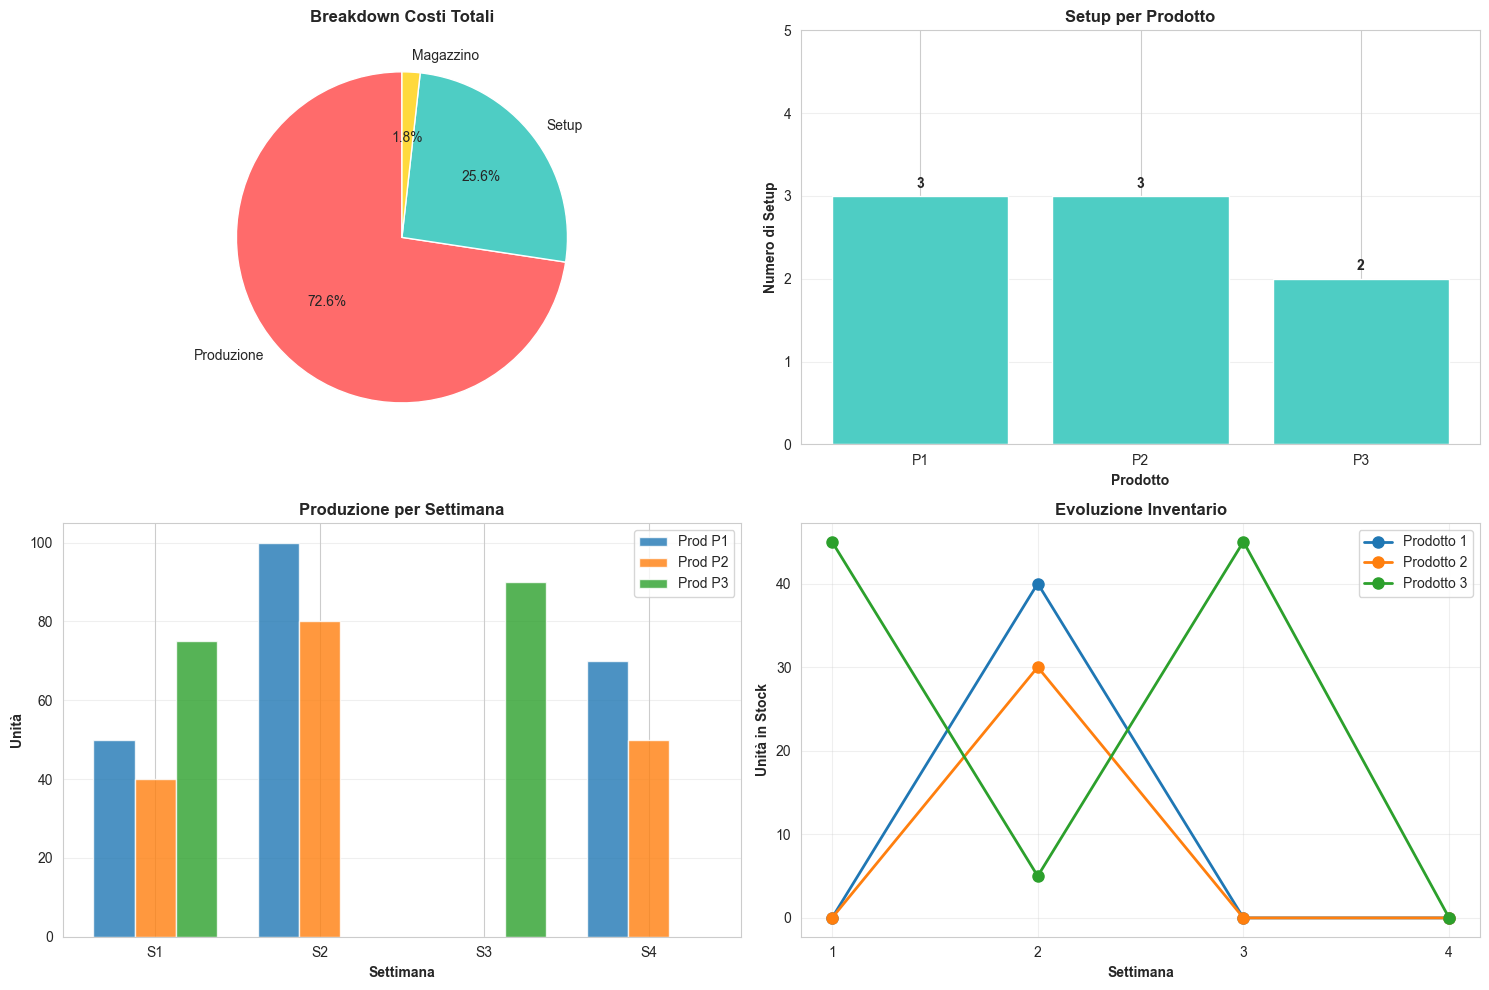

In [15]:
if modello.status == GRB.OPTIMAL:
    # Grafico 1: Breakdown costi
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Pie chart costi
    costi = [costo_prod, costo_setp, costo_inv]
    labels = ['Produzione', 'Setup', 'Magazzino']
    colors = ['#FF6B6B', '#4ECDC4', '#FFD93D']
    
    axes[0, 0].pie(costi, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
    axes[0, 0].set_title('Breakdown Costi Totali', fontweight='bold', fontsize=12)
    
    # Grafico 2: Numero di setup per prodotto
    num_setup_per_prod = [sum(sol_y[p, t] for t in settimane) for p in prodotti]
    axes[0, 1].bar([f'P{p}' for p in prodotti], num_setup_per_prod, color='#4ECDC4')
    axes[0, 1].set_xlabel('Prodotto', fontweight='bold')
    axes[0, 1].set_ylabel('Numero di Setup', fontweight='bold')
    axes[0, 1].set_title('Setup per Prodotto', fontweight='bold', fontsize=12)
    axes[0, 1].set_ylim(0, 5)
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Aggiungi valori
    for i, val in enumerate(num_setup_per_prod):
        axes[0, 1].text(i, val + 0.1, f'{int(val)}', ha='center', fontweight='bold')
    
    # Grafico 3: Produzione vs Domanda nel tempo per ogni prodotto
    x_pos = np.arange(len(settimane))
    width = 0.25
    
    for i, p in enumerate(prodotti):
        produzione = [sol_x[p, t] for t in settimane]
        domande = [domanda[p, t] for t in settimane]
        
        axes[1, 0].bar(x_pos + i*width, produzione, width, 
                      label=f'Prod P{p}', alpha=0.8)
    
    axes[1, 0].set_xlabel('Settimana', fontweight='bold')
    axes[1, 0].set_ylabel('Unità', fontweight='bold')
    axes[1, 0].set_title('Produzione per Settimana', fontweight='bold', fontsize=12)
    axes[1, 0].set_xticks(x_pos + width)
    axes[1, 0].set_xticklabels([f'S{t}' for t in settimane])
    axes[1, 0].legend()
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Grafico 4: Inventario nel tempo
    for p in prodotti:
        inventari = [sol_I[p, t] for t in settimane]
        axes[1, 1].plot(settimane, inventari, marker='o', linewidth=2, 
                       markersize=8, label=f'Prodotto {p}')
    
    axes[1, 1].set_xlabel('Settimana', fontweight='bold')
    axes[1, 1].set_ylabel('Unità in Stock', fontweight='bold')
    axes[1, 1].set_title('Evoluzione Inventario', fontweight='bold', fontsize=12)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_xticks(settimane)
    
    plt.tight_layout()
    plt.show()

## 🔍 Analisi delle Decisioni Binarie

Analizziamo **quando conviene produrre** e **quando no**.

In [16]:
if modello.status == GRB.OPTIMAL:
    print("\n" + "="*70)
    print("           ANALISI STRATEGIA DI PRODUZIONE (Setup)")
    print("="*70)
    
    for p in prodotti:
        print(f"\n📦 PRODOTTO {p}:")
        print("-" * 70)
        
        settimane_con_setup = [t for t in settimane if sol_y[p, t] > 0.5]
        settimane_senza_setup = [t for t in settimane if sol_y[p, t] < 0.5]
        
        print(f"Settimane CON produzione: {settimane_con_setup}")
        print(f"Settimane SENZA produzione: {settimane_senza_setup}")
        print(f"\nCosto setup totale: {len(settimane_con_setup) * costo_setup[p]:.0f}€")
        
        # Analisi produzione anticipata
        print("\n💡 STRATEGIA:")
        for t in settimane:
            if sol_y[p, t] > 0.5:
                prod = sol_x[p, t]
                dom = domanda[p, t]
                if prod > dom + 0.1:
                    extra = prod - dom
                    print(f"  Sett.{t}: Produce {prod:.0f} unità (domanda {dom}) → {extra:.0f} unità in ANTICIPO")
                else:
                    print(f"  Sett.{t}: Produce {prod:.0f} unità (domanda {dom}) → Just-in-time")
            else:
                print(f"  Sett.{t}: NON produce (usa inventario della settimana precedente)")
    
    print("\n" + "="*70)
    print("\n🎯 OSSERVAZIONI CHIAVE:")
    print("-" * 70)
    print("• La soluzione ottima bilancia il TRADE-OFF tra:")
    print("  - Pochi setup (→ meno costi fissi) MA più magazzino")
    print("  - Più setup (→ più costi fissi) MA meno magazzino")
    print("\n• Il modello decide AUTOMATICAMENTE quando conviene:")
    print("  - Produrre in anticipo e pagare magazzino")
    print("  - Fare un setup aggiuntivo per evitare magazzino")
    print("="*70)


           ANALISI STRATEGIA DI PRODUZIONE (Setup)

📦 PRODOTTO 1:
----------------------------------------------------------------------
Settimane CON produzione: [1, 2, 4]
Settimane SENZA produzione: [3]

Costo setup totale: 1500€

💡 STRATEGIA:
  Sett.1: Produce 50 unità (domanda 50) → Just-in-time
  Sett.2: Produce 100 unità (domanda 60) → 40 unità in ANTICIPO
  Sett.3: NON produce (usa inventario della settimana precedente)
  Sett.4: Produce 70 unità (domanda 70) → Just-in-time

📦 PRODOTTO 2:
----------------------------------------------------------------------
Settimane CON produzione: [1, 2, 4]
Settimane SENZA produzione: [3]

Costo setup totale: 2100€

💡 STRATEGIA:
  Sett.1: Produce 40 unità (domanda 40) → Just-in-time
  Sett.2: Produce 80 unità (domanda 50) → 30 unità in ANTICIPO
  Sett.3: NON produce (usa inventario della settimana precedente)
  Sett.4: Produce 50 unità (domanda 50) → Just-in-time

📦 PRODOTTO 3:
----------------------------------------------------------------

## 🧪 Esperimenti: Analisi What-If

### Esperimento 1: Cosa succede se dimezziamo i costi di setup?

In [17]:
# Salviamo i costi originali
costo_setup_originale = costo_setup.copy()
costo_totale_originale = costo_totale
num_setup_originale = {p: sum(sol_y[p, t] for t in settimane) for p in prodotti}

# Dimezziamo i costi di setup
for p in prodotti:
    costo_setup[p] = costo_setup[p] / 2

# Ridefinisco la funzione obiettivo
costo_setup_totale_nuovo = gp.quicksum(
    costo_setup[p] * y[p, t] for p in prodotti for t in settimane
)
funzione_obiettivo_nuova = costo_prod_totale + costo_setup_totale_nuovo + costo_inventario_totale
modello.setObjective(funzione_obiettivo_nuova, GRB.MINIMIZE)

# Risolvo
modello.optimize()

if modello.status == GRB.OPTIMAL:
    print("\n" + "="*70)
    print("    SCENARIO: Costi di Setup DIMEZZATI (50% dei valori originali)")
    print("="*70)
    
    print(f"\nCosto originale: {costo_totale_originale:,.2f} €")
    print(f"Nuovo costo: {modello.ObjVal:,.2f} €")
    print(f"Risparmio: {costo_totale_originale - modello.ObjVal:,.2f} € (-{((1 - modello.ObjVal/costo_totale_originale)*100):.1f}%)")
    
    print("\n📊 CAMBIAMENTO STRATEGIA:")
    print("-" * 70)
    for p in prodotti:
        num_setup_nuovo = sum(y[p, t].X for t in settimane)
        print(f"Prodotto {p}:")
        print(f"  Setup prima: {int(num_setup_originale[p])}")
        print(f"  Setup ora:   {int(num_setup_nuovo)}")
        if num_setup_nuovo > num_setup_originale[p]:
            print(f"  → Fa PIÙ setup! (setup più economico → conviene produrre più spesso)")
        elif num_setup_nuovo < num_setup_originale[p]:
            print(f"  → Fa MENO setup!")
        else:
            print(f"  → Stessa strategia")
    
    print("\n💡 INSIGHT: Con setup più economici, conviene fare più setup e")
    print("    tenere meno inventario (strategia più just-in-time)")
    print("="*70)

# Ripristino
costo_setup = costo_setup_originale.copy()
costo_setup_totale = gp.quicksum(
    costo_setup[p] * y[p, t] for p in prodotti for t in settimane
)
funzione_obiettivo = costo_prod_totale + costo_setup_totale + costo_inventario_totale
modello.setObjective(funzione_obiettivo, GRB.MINIMIZE)
modello.optimize()


    SCENARIO: Costi di Setup DIMEZZATI (50% dei valori originali)

Costo originale: 18,730.00 €
Nuovo costo: 16,330.00 €
Risparmio: 2,400.00 € (-12.8%)

📊 CAMBIAMENTO STRATEGIA:
----------------------------------------------------------------------
Prodotto 1:
  Setup prima: 3
  Setup ora:   3
  → Stessa strategia
Prodotto 2:
  Setup prima: 3
  Setup ora:   3
  → Stessa strategia
Prodotto 3:
  Setup prima: 2
  Setup ora:   2
  → Stessa strategia

💡 INSIGHT: Con setup più economici, conviene fare più setup e
    tenere meno inventario (strategia più just-in-time)


### Esperimento 2: Cosa succede se aumentiamo il costo di magazzino?

In [18]:
# Il costo magazzino passa da 2€ a 5€ per unità per settimana
costo_magazzino_originale = costo_magazzino
costo_magazzino = 5

# Ridefinisco la funzione obiettivo
costo_inventario_totale_nuovo = gp.quicksum(
    costo_magazzino * I[p, t] for p in prodotti for t in settimane)

funzione_obiettivo_nuova = costo_prod_totale + costo_setup_totale + costo_inventario_totale_nuovo
modello.setObjective(funzione_obiettivo_nuova, GRB.MINIMIZE)

# Risolvo
modello.optimize()

if modello.status == GRB.OPTIMAL:
    print("\n" + "="*70)
    print("    SCENARIO: Costo Magazzino AUMENTATO (da 2€ a 5€ per unità)")
    print("="*70)
    
    print(f"\nCosto originale: {costo_totale_originale:,.2f} €")
    print(f"Nuovo costo: {modello.ObjVal:,.2f} €")
    print(f"Aumento: {modello.ObjVal - costo_totale_originale:,.2f} € (+{((modello.ObjVal/costo_totale_originale - 1)*100):.1f}%)")
    
    print("\n📊 CAMBIAMENTO STRATEGIA:")
    print("-" * 70)
    
    inventario_medio_originale = sum(sol_I[p, t] for p in prodotti for t in settimane) / (len(prodotti) * len(settimane))
    inventario_medio_nuovo = sum(I[p, t].X for p in prodotti for t in settimane) / (len(prodotti) * len(settimane))
    
    print(f"Inventario medio prima: {inventario_medio_originale:.1f} unità")
    print(f"Inventario medio ora:   {inventario_medio_nuovo:.1f} unità")
    
    
    for p in prodotti:
        num_setup_nuovo = sum(y[p, t].X for t in settimane)
        if num_setup_nuovo != num_setup_originale[p]:
            print(f"\nProdotto {p}: Passa da {int(num_setup_originale[p])} a {int(num_setup_nuovo)} setup")
    
    print("\n💡 INSIGHT: Con magazzino più costoso, può convenire fare più setup")
    print("    per evitare di tenere prodotti in stock")
    print("="*70)

# Ripristino
costo_magazzino = costo_magazzino_originale
costo_inventario_totale = gp.quicksum(
    costo_magazzino * I[p, t] for p in prodotti for t in settimane
)
funzione_obiettivo = costo_prod_totale + costo_setup_totale + costo_inventario_totale
modello.setObjective(funzione_obiettivo, GRB.MINIMIZE)
modello.optimize()


    SCENARIO: Costo Magazzino AUMENTATO (da 2€ a 5€ per unità)

Costo originale: 18,730.00 €
Nuovo costo: 19,225.00 €
Aumento: 495.00 € (+2.6%)

📊 CAMBIAMENTO STRATEGIA:
----------------------------------------------------------------------
Inventario medio prima: 13.8 unità
Inventario medio ora:   13.8 unità

💡 INSIGHT: Con magazzino più costoso, può convenire fare più setup
    per evitare di tenere prodotti in stock


### Esperimento 3: Cosa succede con una domanda più variabile?

In [19]:
# Creiamo una domanda con picchi più alti
domanda_originale = domanda.copy()

# Prodotto 1: picco nella settimana 4
domanda[1, 4] = 120  # da 70 a 120
domanda[1, 1] = 30   # da 50 a 30

# Aggiorniamo i vincoli
for p in prodotti:
    for t in settimane:
        if t == 1:
            vincoli_inventario[p, t].RHS = 0
            modello.remove(vincoli_inventario[p, t])
            vincoli_inventario[p, t] = modello.addConstr(
                x[p, t] == domanda[p, t] + I[p, t],
                name=f"Inventario_P{p}_S{t}"
            )
        else:
            modello.remove(vincoli_inventario[p, t])
            vincoli_inventario[p, t] = modello.addConstr(
                I[p, t-1] + x[p, t] == domanda[p, t] + I[p, t],
                name=f"Inventario_P{p}_S{t}"
            )

modello.update()
modello.optimize()

if modello.status == GRB.OPTIMAL:
    print("\n" + "="*70)
    print("    SCENARIO: Domanda Prodotto 1 con PICCO in Settimana 4 (120 unità)")
    print("="*70)
    
    print(f"\nCosto originale: {costo_totale_originale:,.2f} €")
    print(f"Nuovo costo: {modello.ObjVal:,.2f} €")
    print(f"Aumento: {modello.ObjVal - costo_totale_originale:,.2f} €")
    
    print("\n📦 STRATEGIA PRODOTTO 1:")
    print("-" * 70)
    for t in settimane:
        print(f"Sett.{t}: Produce {x[1, t].X:>6.1f}, Domanda {domanda[1, t]:>3}, Inventario {I[1, t].X:>6.1f}, Setup: {'✓' if y[1, t].X > 0.5 else '✗'}")
    
    print("\n💡 INSIGHT: Con picchi di domanda, il modello può decidere di")
    print("    produrre in anticipo per evitare problemi di capacità")
    print("="*70)
elif modello.status == GRB.INFEASIBLE:
    print("\n❌ SOLUZIONE NON AMMISSIBILE!")
    print("La capacità produttiva non è sufficiente per il picco di domanda.")

# Ripristino
domanda = domanda_originale.copy()
for p in prodotti:
    for t in settimane:
        modello.remove(vincoli_inventario[p, t])
        if t == 1:
            vincoli_inventario[p, t] = modello.addConstr(
                x[p, t] == domanda[p, t] + I[p, t],
                name=f"Inventario_P{p}_S{t}"
            )
        else:
            vincoli_inventario[p, t] = modello.addConstr(
                I[p, t-1] + x[p, t] == domanda[p, t] + I[p, t],
                name=f"Inventario_P{p}_S{t}"
            )
modello.update()
modello.optimize()


    SCENARIO: Domanda Prodotto 1 con PICCO in Settimana 4 (120 unità)

Costo originale: 18,730.00 €
Nuovo costo: 19,410.00 €
Aumento: 680.00 €

📦 STRATEGIA PRODOTTO 1:
----------------------------------------------------------------------
Sett.1: Produce   90.0, Domanda  30, Inventario   60.0, Setup: ✓
Sett.2: Produce    0.0, Domanda  60, Inventario    0.0, Setup: ✗
Sett.3: Produce   60.0, Domanda  40, Inventario   20.0, Setup: ✓
Sett.4: Produce  100.0, Domanda 120, Inventario    0.0, Setup: ✓

💡 INSIGHT: Con picchi di domanda, il modello può decidere di
    produrre in anticipo per evitare problemi di capacità


## 📝 Esportazione del Modello

In [20]:
# Esportiamo il modello
modello.write("pianificazione_setup.lp")
print("\n✅ Modello esportato in 'pianificazione_setup.lp'")

# Esportiamo la soluzione
modello.write("pianificazione_setup_soluzione.sol")
print("✅ Soluzione esportata in 'pianificazione_setup_soluzione.sol'")


✅ Modello esportato in 'pianificazione_setup.lp'
✅ Soluzione esportata in 'pianificazione_setup_soluzione.sol'
